In [3]:
from importlib import reload

import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

sys.path.append(parent_dir)

import src

from src.utils import load_MNIST_data
from src.model import Simple_Model
from src.train import train_model
from src.inference import evaluate_overall, evaluate_classwise, confusion_matrix_plot, plot_roc_curves
reload(src.train)
reload(src.model)
reload(src.utils)
reload(src.inference)

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt



In [4]:

print(torch.__version__)
print(torch.backends.mps.is_built())      # Should be True
print(torch.backends.mps.is_available())  # Should now be True

2.8.0
True
True


In [5]:
train_dloader, val_dloader, test_dloader = load_MNIST_data(batch_size = 512, num_workers=4) # try increase batch size to 128

In [6]:
print(len(train_dloader.dataset))
print(len(val_dloader.dataset))
print(len(test_dloader.dataset))

288000
12000
10000


In [7]:
from torch.optim.lr_scheduler import OneCycleLR

device = torch.device("mps")
print(f"Using device: {device}")

CNN_model = Simple_Model(out_channels = 6, 
                         kernel_size = 5)


epochs = 2

loss_fcn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params = CNN_model.parameters(), lr = 0.001, momentum = 0.9)
scheduler = OneCycleLR(
    optimiser,
    max_lr=2e-3,
    steps_per_epoch=len(train_dloader),
    epochs=epochs,
    pct_start=0.3,      # portion of cycle to increase LR
    anneal_strategy='cos',  # cosine annealing down
)

scaler = torch.amp.GradScaler(device)

for epoch in range(epochs):
    train_loss, val_loss, val_acc = train_model(CNN_model, optimiser, loss_fcn, train_dloader, val_dloader, 
                                                epoch, device, scaler, scheduler, print_training = True)

    



Using device: mps


[Epoch  1] Training accuracy: 48.21%, Validation accuracy: 64.55%


[Epoch  2] Training accuracy: 66.86%, Validation accuracy: 69.38%


In [22]:
test_acc = evaluate_overall(CNN_model, test_dloader, device)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.7028


In [23]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

In [24]:
classwise_acc = evaluate_classwise(CNN_model, test_dloader, device, class_names)
for classname, acc in classwise_acc.items():
    print(f"Class: {classname}  Accuracy: {acc:.4f}")

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/leonwindett/anaconda3/envs/uni_conda/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonwindett/anaconda3/envs/uni_conda/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/leonwindett/anaconda3/envs/uni_conda/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonwindett/anaconda3/envs/uni_conda/lib/python3.11/site-packages/torchvision/__init__.py", line 10, in <module>
    exitcode = _main(fd, parent_sentinel)
          Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/leonwindett/anaconda3/envs/uni_conda/lib/python3.11/multip

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/leonwindett/anaconda3/envs/uni_conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/xh/bqjqk9456z5glbmmsrfznf_80000gn/T/ipykernel_88179/2794268671.py", line 1, in <module>
    classwise_acc = evaluate_classwise(CNN_model, test_dloader, device, class_names)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonwindett/VS_CODE/Projects/FASHION-MNIST-CNN/src/inference.py", line 35, in evaluate_classwise
    for inputs, targets in test_dloader:
  File "/Users/leonwindett/anaconda3/envs/uni_conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 734, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/Users/leonwindett/anaconda3/envs/uni_conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1492, in _next_data
    idx

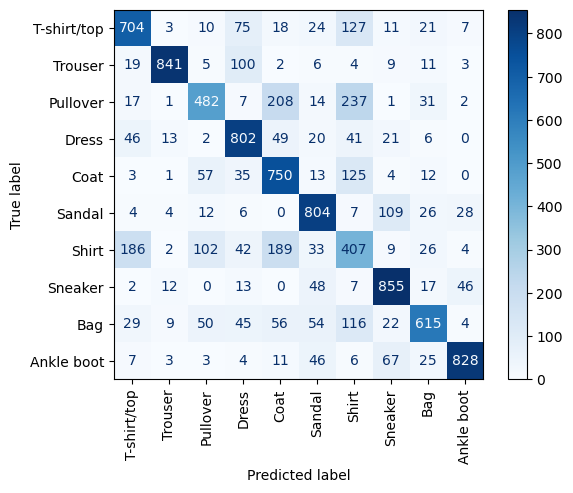

In [ ]:
confusion_matrix = confusion_matrix_plot(CNN_model, test_dloader, device, class_names)

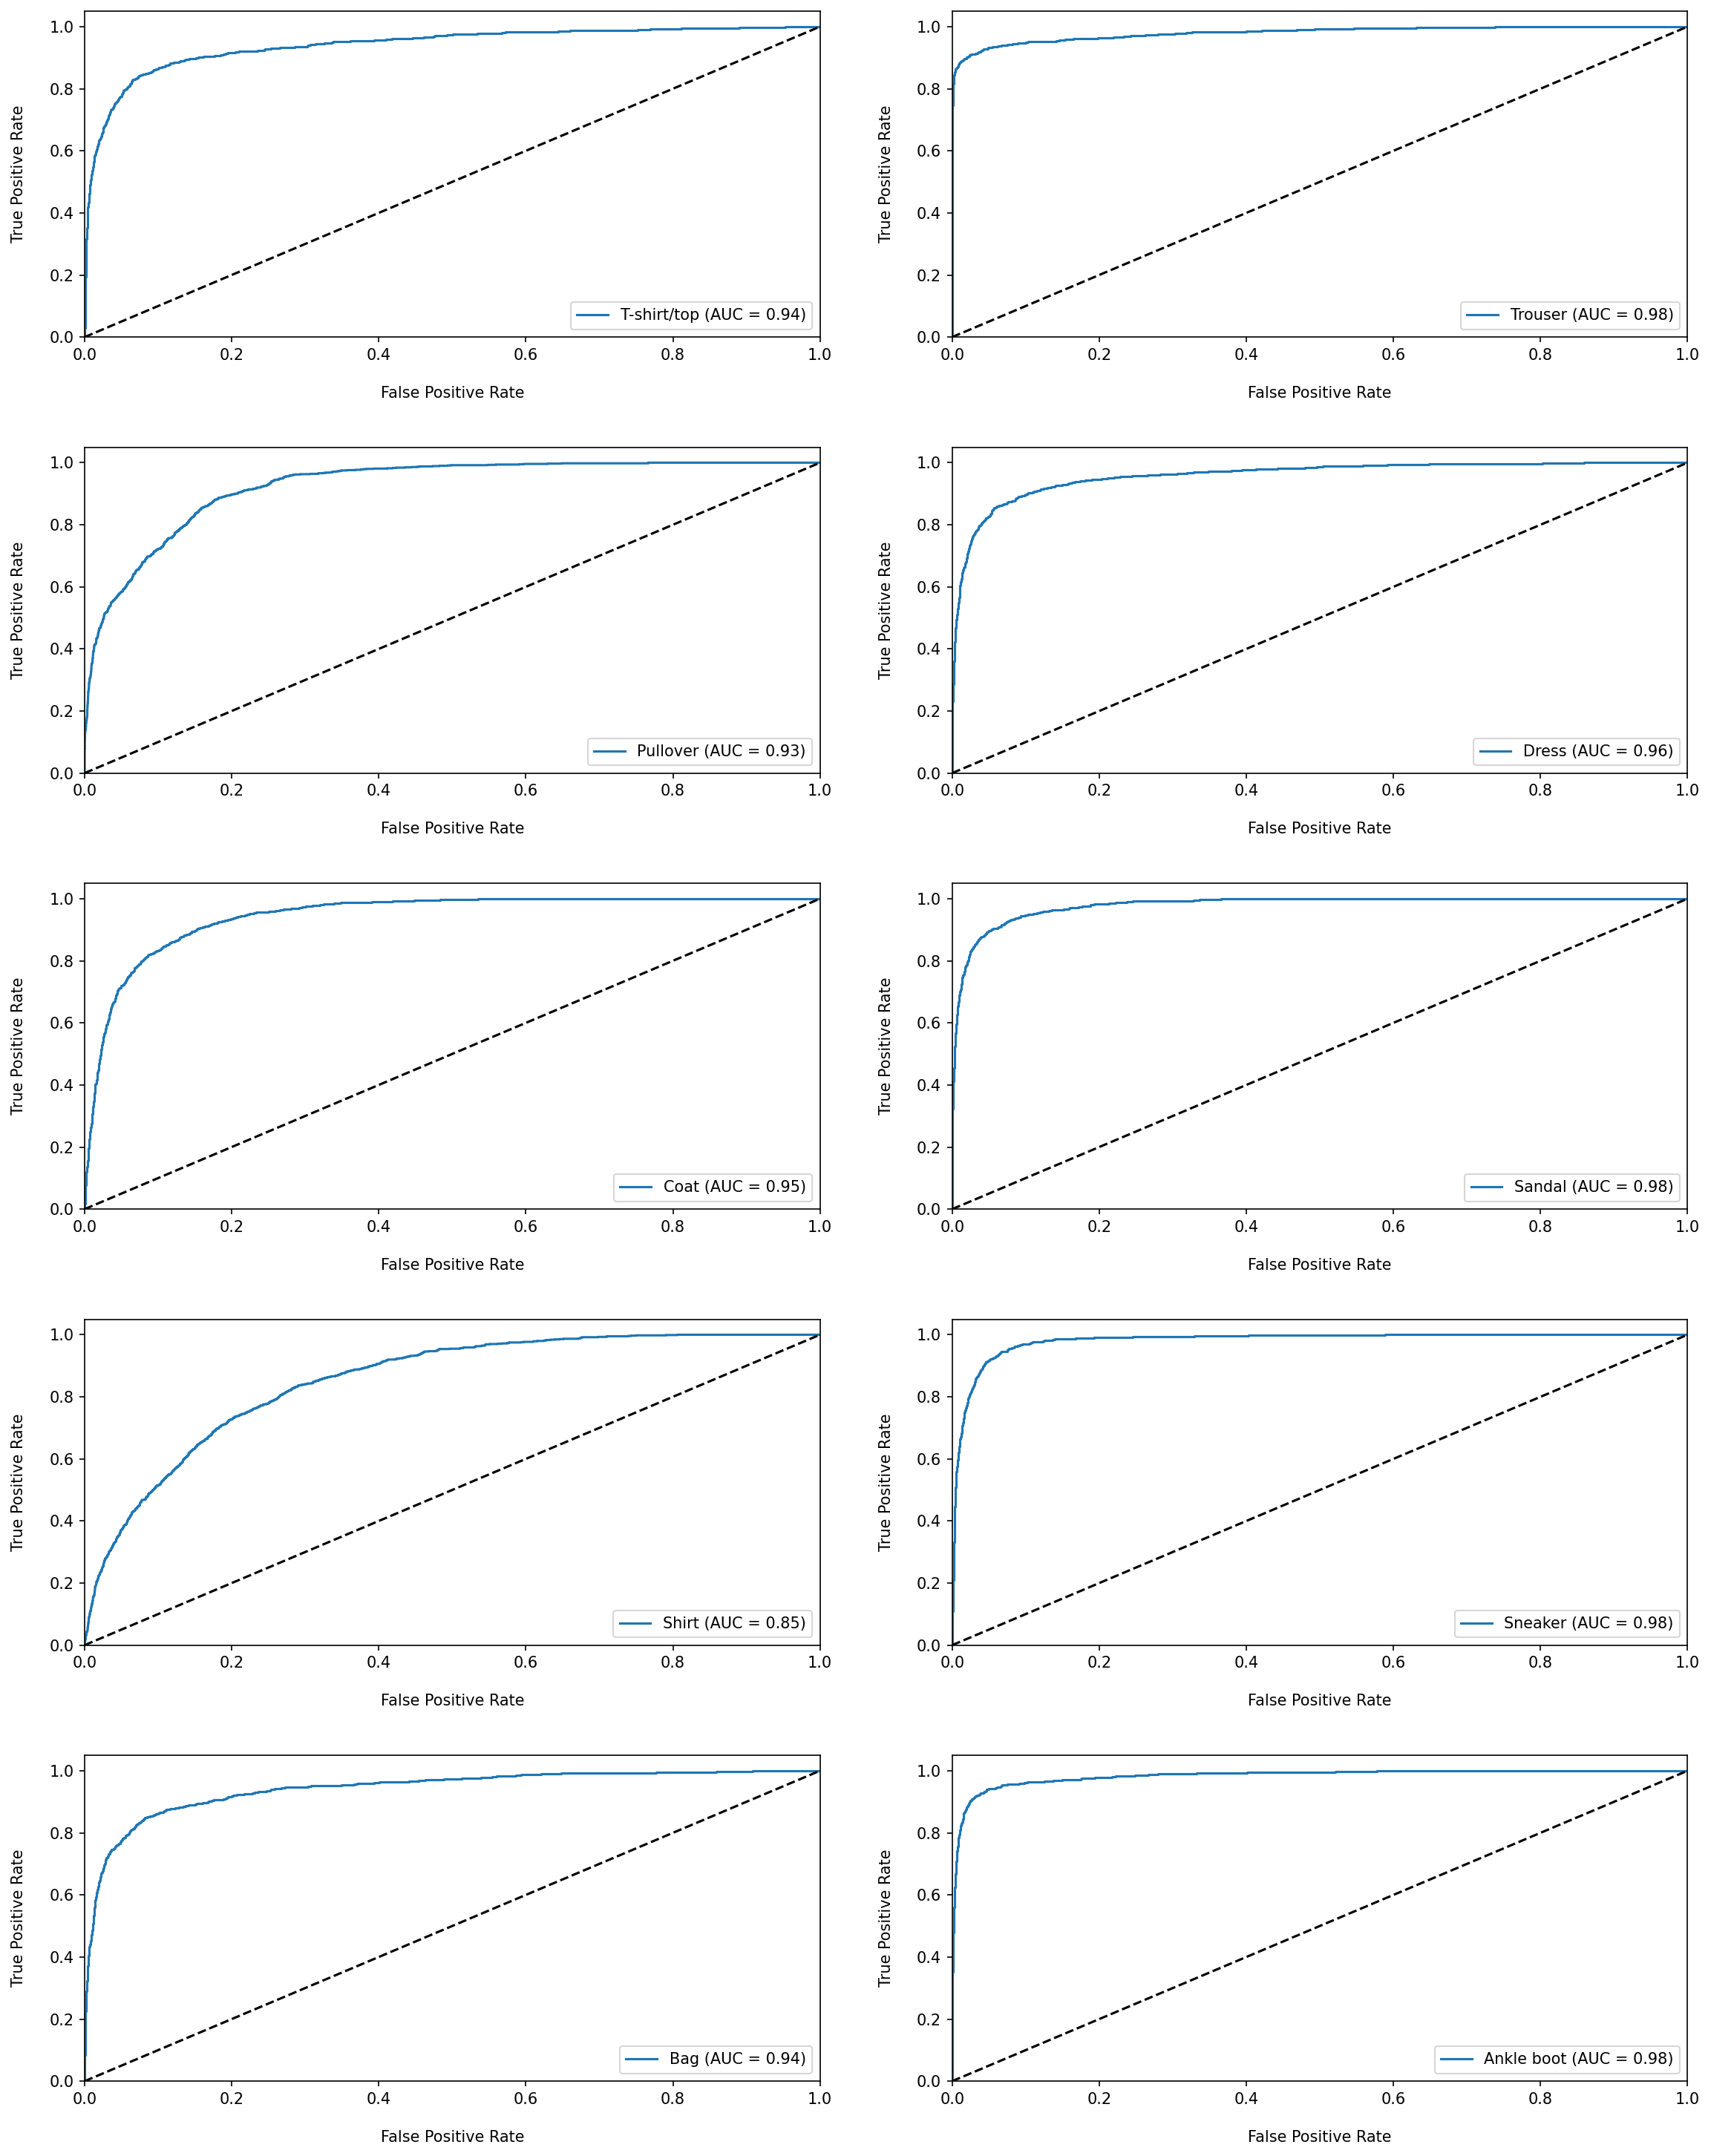

In [ ]:
fig = plot_roc_curves(CNN_model, test_dloader, device, class_names)
plt.show()